## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)

## Section 1: Dataset Overview

In [2]:
heart_df = pd.read_csv("heart.csv")
target_column = 'HeartDisease'  # when we choose the dataset we need to put the name of the target column here
print('\n--- Dataset Overview ---')
print(f'Number of rows: {heart_df.shape[0]}, Number of columns: {heart_df.shape[1]}')
print(f'\nFirst 5 rows:\n{heart_df.head(5)}')


--- Dataset Overview ---
Number of rows: 918, Number of columns: 12

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [3]:
print('\n--- Column Information ---')
print(heart_df.info())

print('\n--- Statistical Summary ---')
print(heart_df.describe())


--- Column Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

--- Statistical Summary ---
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   


In [ ]:
print('\n--- Missing Values Check ---')
print('Null values in each column:')
print(heart_df.isnull().sum())
print(f'\nTotal missing values: {heart_df.isnull().sum().sum()}')

print('\n--- Duplicate Check ---')
print(f'Number of duplicate rows: {heart_df.duplicated().sum()}')


--- Missing Values Check ---
Null values in each column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Total missing values: 0

--- Duplicate Check ---
Number of duplicate rows: 0


In [ ]:
print('\n--- Categorical Features Distribution ---')
print(f"\nSex distribution:\n{heart_df['Sex'].value_counts()}")
print(f"\nExerciseAngina unique values: {heart_df['ExerciseAngina'].nunique()}")
print(f"\nChestPainType unique values: {heart_df['ChestPainType'].nunique()}")
print(f"\nRestingECG unique values: {heart_df['RestingECG'].nunique()}")
print(f"\nST_Slope unique values: {heart_df['ST_Slope'].nunique()}")


--- Categorical Features Distribution ---

Sex distribution:
Sex
M    725
F    193
Name: count, dtype: int64

ExerciseAngina unique values: 2

ChestPainType unique values: 4

RestingECG unique values: 3

ST_Slope unique values: 3


In [ ]:
zero_cholesterol_count = (heart_df['Cholesterol'] == 0).sum()
print(f"There are {zero_cholesterol_count} rows with 0 cholesterol values.")

zero_RBP_count = (heart_df['RestingBP'] == 0).sum()
print(f"There are {zero_RBP_count} rows with 0 RBP values.")

There are 172 rows with 0 cholesterol values.
There are 1 rows with 0 RBP values.


## Section 2: Data Visualization and Outlier Detection

In [ ]:
print("\n" + "="*80)
print("SECTION 2: DATA VISUALIZATION AND OUTLIER DETECTION")
print("="*80)

num_cols = heart_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = heart_df.select_dtypes(include=['object']).columns.tolist()

print(f'\nNumerical columns ({len(num_cols)}): {num_cols}')
print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')


SECTION 2: DATA VISUALIZATION AND OUTLIER DETECTION

Numerical columns (7): ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
Categorical columns (5): ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [ ]:
kurtosis=None   
print('\n--- Kurtosis Analysis ---')
for col in num_cols:
    kurtosis = heart_df[col].kurtosis()
    print(f"{col:30s} → Kurtosis: {kurtosis:7.2f}")
    if kurtosis > 3:
        print(f"  → {col} has a leptokurtic distribution, we have more noise and outliers.")


--- Kurtosis Analysis ---
Age                            → Kurtosis:   -0.39
RestingBP                      → Kurtosis:    3.27
  → RestingBP has a leptokurtic distribution, we have more noise and outliers.
Cholesterol                    → Kurtosis:    0.12
FastingBS                      → Kurtosis:   -0.40
MaxHR                          → Kurtosis:   -0.45
Oldpeak                        → Kurtosis:    1.20
HeartDisease                   → Kurtosis:   -1.96


In [ ]:
print('\n--- Skewness Analysis ---')
for col in num_cols:
    skewness = heart_df[col].skew()
    print(f"{col:30s} → Skewness: {skewness:7.2f}")
    
    if skewness > 0.5:
        print(f"  → {col} is positively skewed (right-skewed, long tail to the right).")
    elif skewness < -0.5:
        print(f"  → {col} is negatively skewed (left-skewed, long tail to the left).")
    else:
        print(f"  → {col} is approximately symmetric.")


--- Skewness Analysis ---
Age                            → Skewness:   -0.20
  → Age is approximately symmetric.
RestingBP                      → Skewness:    0.18
  → RestingBP is approximately symmetric.
Cholesterol                    → Skewness:   -0.61
  → Cholesterol is negatively skewed (left-skewed, long tail to the left).
FastingBS                      → Skewness:    1.26
  → FastingBS is positively skewed (right-skewed, long tail to the right).
MaxHR                          → Skewness:   -0.14
  → MaxHR is approximately symmetric.
Oldpeak                        → Skewness:    1.02
  → Oldpeak is positively skewed (right-skewed, long tail to the right).
HeartDisease                   → Skewness:   -0.22
  → HeartDisease is approximately symmetric.


In [ ]:
print('\n--- Creating boxplots for outlier detection ---')
heart_df[num_cols].boxplot(figsize=(12, 8))
plt.title('Boxplot of All Numerical Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Creating boxplots for outlier detection ---



--- Creating histograms for numerical features ---


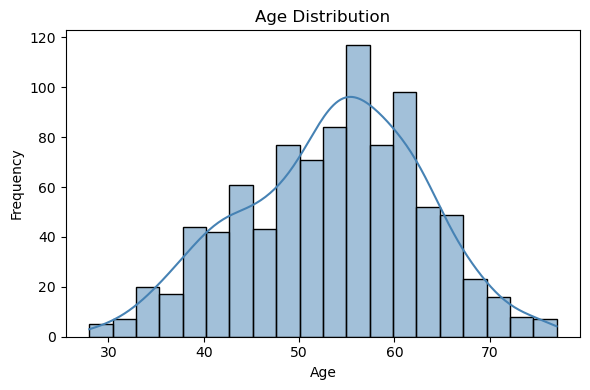

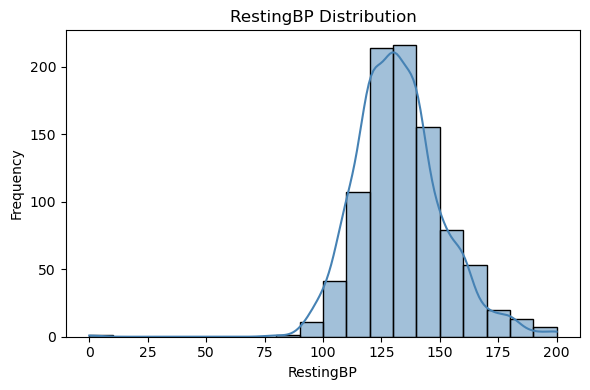

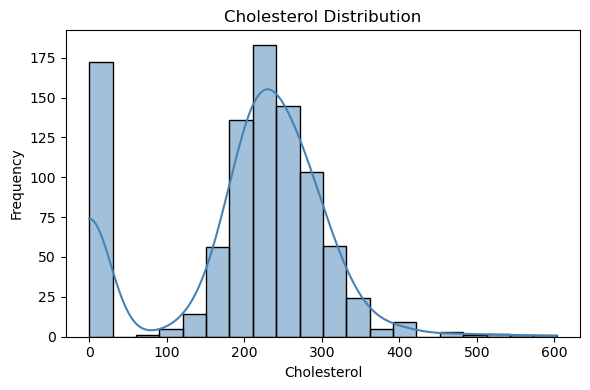

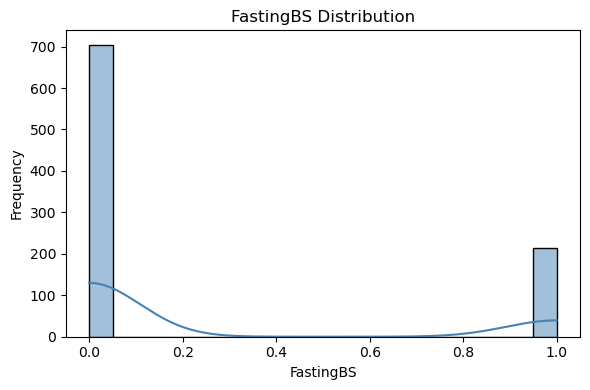

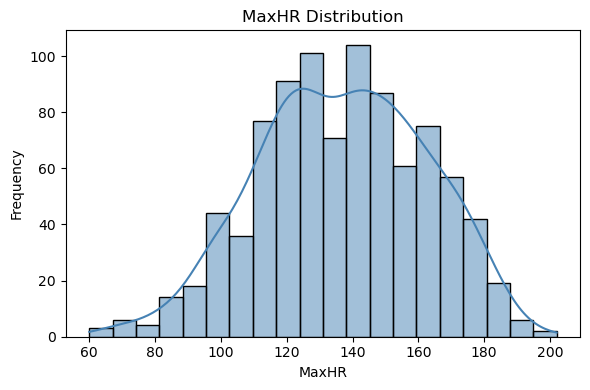

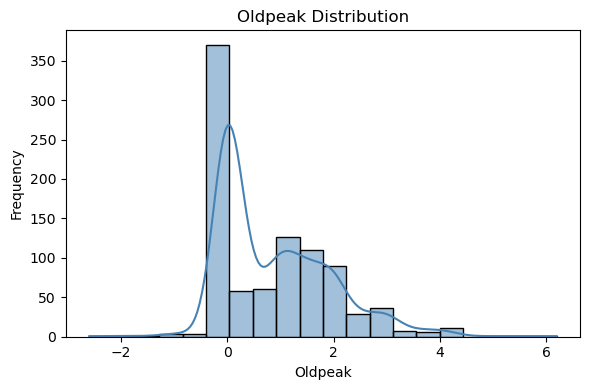

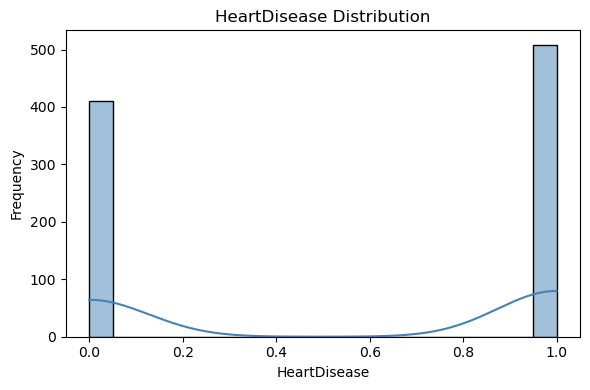

In [ ]:
print('\n--- Creating histograms for numerical features ---')
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(heart_df[col], kde=True, bins=20, color="steelblue")
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [ ]:
print('\n--- Correlation Analysis ---')
corr_matrix = heart_df[num_cols].corr()
print('Correlation matrix:')
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


--- Correlation Analysis ---
Correlation matrix:
                   Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
Age           1.000000   0.254399    -0.095282   0.198039 -0.382045  0.258612   
RestingBP     0.254399   1.000000     0.100893   0.070193 -0.112135  0.164803   
Cholesterol  -0.095282   0.100893     1.000000  -0.260974  0.235792  0.050148   
FastingBS     0.198039   0.070193    -0.260974   1.000000 -0.131438  0.052698   
MaxHR        -0.382045  -0.112135     0.235792  -0.131438  1.000000 -0.160691   
Oldpeak       0.258612   0.164803     0.050148   0.052698 -0.160691  1.000000   
HeartDisease  0.282039   0.107589    -0.232741   0.267291 -0.400421  0.403951   

              HeartDisease  
Age               0.282039  
RestingBP         0.107589  
Cholesterol      -0.232741  
FastingBS         0.267291  
MaxHR            -0.400421  
Oldpeak           0.403951  
HeartDisease      1.000000  


## Section 3: Data Cleaning

In [ ]:
print("\n" + "="*80)
print("SECTION 3: DATA CLEANING")
print("="*80)

heart_df_clean = heart_df.copy()
print('\n--- 3.1: Handling Duplicates ---')
duplicates_before = heart_df_clean.duplicated().sum()
heart_df_clean.drop_duplicates(inplace=True)
print(f'Duplicates removed: {duplicates_before}')
print(f'Rows remaining: {heart_df_clean.shape[0]}')


SECTION 3: DATA CLEANING

--- 3.1: Handling Duplicates ---
Duplicates removed: 0
Rows remaining: 918


In [14]:
print('\n--- 3.2: Cleaning Column Names ---')
heart_df_clean.columns = [col.strip().replace(' ', '_') for col in heart_df_clean.columns]
print(f'Cleaned column names: {heart_df_clean.columns.tolist()}')


--- 3.2: Cleaning Column Names ---
Cleaned column names: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [15]:
print('\n--- 3.3: Missing Values Strategy ---')
missing_summary = heart_df_clean.isnull().sum()
print('Missing values per column:')
print(missing_summary[missing_summary > 0])


--- 3.3: Missing Values Strategy ---
Missing values per column:
Series([], dtype: int64)


In [16]:
print('\n--- Dropping columns with >80% missing values ---')
missing_percentage = (heart_df_clean.isnull().sum() / len(heart_df_clean)) * 100
cols_to_drop = missing_percentage[missing_percentage > 80].index.tolist()

if cols_to_drop:
    print(f'Columns to drop (>80% missing): {cols_to_drop}')
    for col in cols_to_drop:
        print(f'  - {col}: {missing_percentage[col]:.2f}% missing')
    heart_df_clean.drop(columns=cols_to_drop, inplace=True)
    print(f'Dropped {len(cols_to_drop)} column(s)')
    print(f'Remaining columns: {heart_df_clean.shape[1]}')
else:
    print('No columns with >80% missing values found')

print('\nStrategy for remaining missing values:')
print('  - Numerical: median imputation (via pipeline)')
print('  - Categorical: most frequent imputation (via pipeline)')


--- Dropping columns with >80% missing values ---
No columns with >80% missing values found

Strategy for remaining missing values:
  - Numerical: median imputation (via pipeline)
  - Categorical: most frequent imputation (via pipeline)


In [ ]:
print('\n--- 3.4: Outlier Detection ---')
for col in heart_df_clean.select_dtypes(include=np.number).columns:
    Q1 = heart_df_clean[col].quantile(0.25)
    Q3 = heart_df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = heart_df_clean[(heart_df_clean[col] < lower_bound) | (heart_df_clean[col] > upper_bound)][col]
    print(f'{col:30s}: {len(outliers):5d} outliers detected (kept for now)')


--- 3.4: Outlier Detection ---
Age                           :     0 outliers detected (kept for now)
RestingBP                     :    28 outliers detected (kept for now)
Cholesterol                   :   183 outliers detected (kept for now)
FastingBS                     :   214 outliers detected (kept for now)
MaxHR                         :     2 outliers detected (kept for now)
Oldpeak                       :    16 outliers detected (kept for now)
HeartDisease                  :     0 outliers detected (kept for now)


## Section 4: Train-Test Split

In [18]:
print("\n" + "="*80)
print("SECTION 4: TRAIN-TEST SPLIT")
print("="*80)

print(f'\n--- 5.1: Separating Features and Target ---')
print(f'Target column: {target_column}')

X = heart_df_clean.drop(target_column, axis=1)
y = heart_df_clean[target_column]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')


SECTION 4: TRAIN-TEST SPLIT

--- 5.1: Separating Features and Target ---
Target column: HeartDisease
Features shape: (918, 11)
Target shape: (918,)


In [19]:
class_counts = y.value_counts()
if len(class_counts) == 2:
    majority_class = class_counts.max()
    minority_class = class_counts.min()
    imbalance_ratio = majority_class / minority_class
    print(f'\nClass imbalance ratio: {imbalance_ratio:.2f}:1')
    if imbalance_ratio > 3:
        print(f'  Warning: Significant class imbalance detected!')
        print(f'   Consider using stratified split or resampling techniques.')


Class imbalance ratio: 1.24:1


In [20]:
print('\n--- 5.2: Creating Train-Test Split (80/20) ---')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f'Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)')
print(f'\nTraining target distribution:\n{y_train.value_counts()}')
print(f'\nTest target distribution:\n{y_test.value_counts()}')


--- 5.2: Creating Train-Test Split (80/20) ---
Training set size: 734 (80.0%)
Test set size: 184 (20.0%)

Training target distribution:
HeartDisease
1    401
0    333
Name: count, dtype: int64

Test target distribution:
HeartDisease
1    107
0     77
Name: count, dtype: int64


## Section 5: Feature Type Isolation

In [ ]:
print("\n" + "="*80)
print("SECTION 5: FEATURE TYPE ISOLATION")
print("="*80)

print('\n--- 5.1: Identifying Feature Types ---')
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f'Numerical features ({len(numerical_features)}): {numerical_features}')
print(f'Categorical features ({len(categorical_features)}): {categorical_features}')


SECTION 5: FEATURE TYPE ISOLATION

--- 5.1: Identifying Feature Types ---
Numerical features (6): ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features (5): ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [ ]:
x_train_num = X_train[numerical_features]
x_train_cat = X_train[categorical_features]

print(f'\n--- 6.2: Feature Type DataFrames ---')
print(f'x_train_num shape: {x_train_num.shape}')
print(f'x_train_cat shape: {x_train_cat.shape}')
print(f'\nMissing values in numerical features:\n{x_train_num.isnull().sum()}')
print(f'\nMissing values in categorical features:\n{x_train_cat.isnull().sum()}')


--- 6.2: Feature Type DataFrames ---
x_train_num shape: (734, 6)
x_train_cat shape: (734, 5)

Missing values in numerical features:
Age            0
RestingBP      0
Cholesterol    0
FastingBS      0
MaxHR          0
Oldpeak        0
dtype: int64

Missing values in categorical features:
Sex               0
ChestPainType     0
RestingECG        0
ExerciseAngina    0
ST_Slope          0
dtype: int64


## Section 6: Transformation Pipelines

In [ ]:
class ZeroCholesterolImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Cholesterol'] = X['Cholesterol'].replace(0, np.nan)
        return X

In [24]:
numerical_transformer = Pipeline(steps=[
    ('cholesterol_imputer', ZeroCholesterolImputer()),
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)

print(f'Original training shape: {X_train.shape}')
print(f'Transformed training shape: {X_train_transformed.shape}')

feature_names = numerical_features.copy()
if len(categorical_features) > 0:
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
    feature_names.extend(cat_feature_names)

print(f'\nTotal features after transformation: {len(feature_names)}')

Original training shape: (734, 11)
Transformed training shape: (734, 15)

Total features after transformation: 15


In [27]:
X_train_final = pd.DataFrame(X_train_transformed, columns=feature_names)

print('\n--- Training Data Statistics After Transformation ---')
print(X_train_final.describe())


--- Training Data Statistics After Transformation ---
                Age     RestingBP   Cholesterol     FastingBS         MaxHR  \
count  7.340000e+02  7.340000e+02  7.340000e+02  7.340000e+02  7.340000e+02   
mean  -2.081290e-16  5.324230e-16 -5.082220e-17 -2.057089e-17 -4.452993e-16   
std    1.000682e+00  1.000682e+00  1.000682e+00  1.000682e+00  1.000682e+00   
min   -2.634267e+00 -7.221389e+00 -3.143577e+00 -5.427086e-01 -3.009580e+00   
25%   -7.107599e-01 -7.089855e-01 -5.720569e-01 -5.427086e-01 -7.181763e-01   
50%    3.727049e-02 -1.662852e-01 -1.368765e-01 -5.427086e-01  7.196296e-02   
75%    6.784394e-01  3.764152e-01  4.961132e-01 -5.427086e-01  7.435813e-01   
max    2.495085e+00  3.632617e+00  7.102943e+00  1.842609e+00  2.600409e+00   

            Oldpeak       Sex_M  ChestPainType_ATA  ChestPainType_NAP  \
count  7.340000e+02  734.000000         734.000000         734.000000   
mean   8.712377e-17    0.773842           0.189373           0.220708   
std    1.00068

In [28]:
print('\n--- 8.2: Transforming Test Data ---')
X_test_transformed = preprocessor.transform(X_test)

print(f'Original test shape: {X_test.shape}')
print(f'Transformed test shape: {X_test_transformed.shape}')

X_test_final = pd.DataFrame(X_test_transformed, columns=feature_names)


--- 8.2: Transforming Test Data ---
Original test shape: (184, 11)
Transformed test shape: (184, 15)


## Section 7: Random Forest Classifier

In [29]:
print("\n" + "="*80)
print("SECTION 7: RANDOM FOREST CLASSIFIER")
print("="*80)


SECTION 7: RANDOM FOREST CLASSIFIER


In [ ]:
print('\n--- 7.2: Training Basic Random Forest Model ---')

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_transformed, y_train)

print('Random Forest model trained successfully!')
print(f'Number of trees: {rf_model.n_estimators}')
print(f'Max depth: {rf_model.max_depth}')


--- 7.2: Training Basic Random Forest Model ---
Random Forest model trained successfully!
Number of trees: 100
Max depth: 10
Random Forest model trained successfully!
Number of trees: 100
Max depth: 10


In [ ]:
print('\n--- 7.3: Making Predictions ---')

y_train_pred_rf = rf_model.predict(X_train_transformed)
y_test_pred_rf = rf_model.predict(X_test_transformed)

print(f'Training predictions shape: {y_train_pred_rf.shape}')
print(f'Test predictions shape: {y_test_pred_rf.shape}')

print(f'\nFirst 20 test set predictions:')
print(f"{'Index':<8} {'Actual':<10} {'Predicted':<12} {'Match':<10}")
print("-"*45)
for i in range(min(20, len(y_test))):
    actual = y_test.iloc[i]
    predicted = y_test_pred_rf[i]
    match = "✓" if actual == predicted else "✗"
    print(f"{i:<8} {actual:<10} {predicted:<12} {match:<10}")


--- 7.3: Making Predictions ---
Training predictions shape: (734,)
Test predictions shape: (184,)

First 20 test set predictions:
Index    Actual     Predicted    Match     
---------------------------------------------
0        0          0            ✓         
1        1          1            ✓         
2        1          1            ✓         
3        1          1            ✓         
4        0          0            ✓         
5        1          1            ✓         
6        1          1            ✓         
7        0          0            ✓         
8        1          1            ✓         
9        1          1            ✓         
10       0          1            ✗         
11       0          0            ✓         
12       0          1            ✗         
13       0          0            ✓         
14       1          1            ✓         
15       1          1            ✓         
16       0          0            ✓         
17       1          1          

In [ ]:
print('\n--- 7.4: Model Performance Evaluation ---')

train_acc = accuracy_score(y_train, y_train_pred_rf)
test_acc = accuracy_score(y_test, y_test_pred_rf)
test_prec = precision_score(y_test, y_test_pred_rf, zero_division=0)
test_rec = recall_score(y_test, y_test_pred_rf, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred_rf, zero_division=0)

print(f"\n{'='*70}")
print("OVERALL PERFORMANCE METRICS")
print(f"{'='*70}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Precision:         {test_prec:.4f}")
print(f"Recall:            {test_rec:.4f}")
print(f"F1-Score:          {test_f1:.4f}")

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred_rf, zero_division=0)
print(f"\n{'='*70}")
print("PER-CLASS METRICS")
print(f"{'='*70}")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*70)
for cls in sorted(y_test.unique()):
    class_name = f"Class {cls}"
    print(f"{class_name:<15} {p[cls]:<12.4f} {r[cls]:<12.4f} {f[cls]:<12.4f} {s[cls]:<10}")

cm = confusion_matrix(y_test, y_test_pred_rf)
print(f"\n{'='*70}")
print("CONFUSION MATRIX")
print(f"{'='*70}")
print(cm)
print(f"\nInterpretation:")
print(f"  True Negatives (TN):  {cm[0,0]}")
print(f"  False Positives (FP): {cm[0,1]}")
print(f"  False Negatives (FN): {cm[1,0]}")
print(f"  True Positives (TP):  {cm[1,1]}")

print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print(f"{'='*70}")
print(classification_report(y_test, y_test_pred_rf, digits=4))

print(f"\n{'='*70}")
print("OVERFITTING ANALYSIS")
print(f"{'='*70}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Difference:        {(train_acc - test_acc):.4f}")

if (train_acc - test_acc) < 0.05:
    print("✓ Model shows good generalization (minimal overfitting)")
elif (train_acc - test_acc) < 0.15:
    print("⚠ Model shows moderate overfitting")
else:
    print("✗ Model shows significant overfitting - consider regularization")


--- 7.4: Model Performance Evaluation ---

OVERALL PERFORMANCE METRICS
Training Accuracy: 0.9823
Test Accuracy:     0.8587
Precision:         0.8857
Recall:            0.8692
F1-Score:          0.8774

PER-CLASS METRICS
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Class 0         0.8228       0.8442       0.8333       77        
Class 1         0.8857       0.8692       0.8774       107       

CONFUSION MATRIX
[[65 12]
 [14 93]]

Interpretation:
  True Negatives (TN):  65
  False Positives (FP): 12
  False Negatives (FN): 14
  True Positives (TP):  93

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.8228    0.8442    0.8333        77
           1     0.8857    0.8692    0.8774       107

    accuracy                         0.8587       184
   macro avg     0.8542    0.8567    0.8553       184
weighted avg     0.8594    0.8587    0.8589       184


--- 7.5: Feature Importance Analysis ---

Top 10 Most Important Features:
          Feature  Importance
      ST_Slope_Up    0.160498
    ST_Slope_Flat    0.119388
          Oldpeak    0.115304
            MaxHR    0.114014
 ExerciseAngina_Y    0.107241
              Age    0.093054
      Cholesterol    0.073063
        RestingBP    0.066537
            Sex_M    0.037498
ChestPainType_ATA    0.037342

Top 10 Most Important Features:
          Feature  Importance
      ST_Slope_Up    0.160498
    ST_Slope_Flat    0.119388
          Oldpeak    0.115304
            MaxHR    0.114014
 ExerciseAngina_Y    0.107241
              Age    0.093054
      Cholesterol    0.073063
        RestingBP    0.066537
            Sex_M    0.037498
ChestPainType_ATA    0.037342


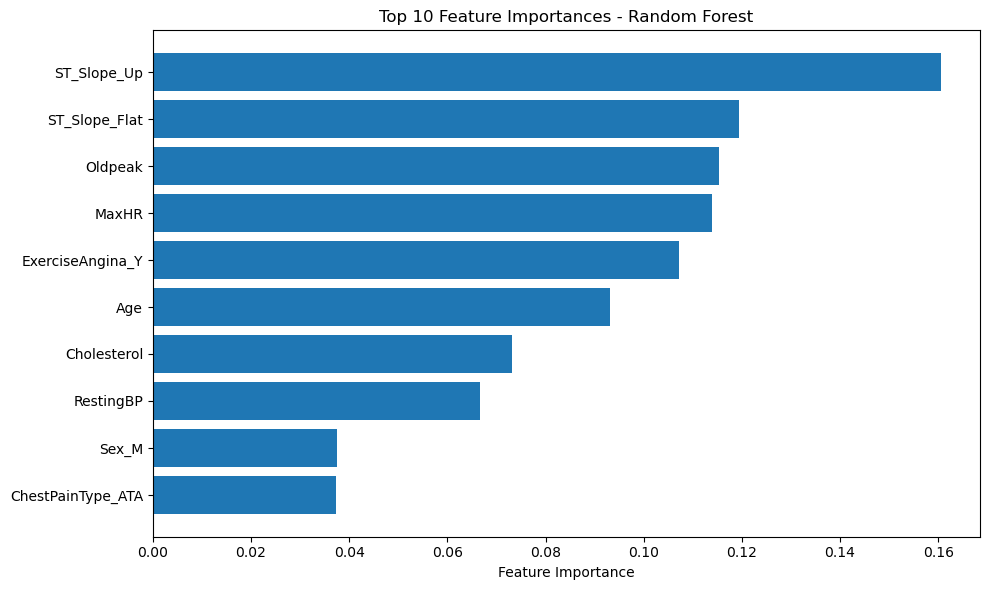

In [33]:
print('\n--- 7.5: Feature Importance Analysis ---')

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print('\nTop 10 Most Important Features:')
print(feature_importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 7.6 Hyperparameter Tuning with Grid Search

In [34]:
print('\n--- 7.6: Hyperparameter Tuning with GridSearchCV ---')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print('Parameter grid:')
for param, values in param_grid.items():
    print(f'  {param}: {values}')

rf_base = RandomForestClassifier(random_state=42)

print('\nRunning GridSearchCV with 3-fold cross-validation...')

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

print('\nGridSearchCV completed!')


--- 7.6: Hyperparameter Tuning with GridSearchCV ---
Parameter grid:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]

Running GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

GridSearchCV completed!

GridSearchCV completed!


In [ ]:
print('\n--- 7.7: Best Model from Grid Search ---')

print(f"\n{'='*70}")
print("GRID SEARCH RESULTS")
print(f"{'='*70}")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_

y_test_pred_best = best_rf_model.predict(X_test_transformed)
y_train_pred_best = best_rf_model.predict(X_train_transformed)

train_acc_best = accuracy_score(y_train, y_train_pred_best)
test_acc_best = accuracy_score(y_test, y_test_pred_best)
test_prec_best = precision_score(y_test, y_test_pred_best, zero_division=0)
test_rec_best = recall_score(y_test, y_test_pred_best, zero_division=0)
test_f1_best = f1_score(y_test, y_test_pred_best, zero_division=0)

print(f"\n{'='*70}")
print("BEST MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Training Accuracy: {train_acc_best:.4f}")
print(f"Test Accuracy:     {test_acc_best:.4f}")
print(f"Precision:         {test_prec_best:.4f}")
print(f"Recall:            {test_rec_best:.4f}")
print(f"F1-Score:          {test_f1_best:.4f}")

cm_best = confusion_matrix(y_test, y_test_pred_best)
print(f"\n{'='*70}")
print("CONFUSION MATRIX - BEST MODEL")
print(f"{'='*70}")
print(cm_best)

print(f"\n{'='*70}")
print("CLASSIFICATION REPORT - BEST MODEL")
print(f"{'='*70}")
print(classification_report(y_test, y_test_pred_best, digits=4))

print(f"\n{'='*70}")
print("OVERFITTING ANALYSIS - BEST MODEL")
print(f"{'='*70}")
print(f"Training Accuracy: {train_acc_best:.4f}")
print(f"Test Accuracy:     {test_acc_best:.4f}")
print(f"Difference:        {(train_acc_best - test_acc_best):.4f}")


--- 7.7: Best Model from Grid Search ---

GRID SEARCH RESULTS

Best parameters found:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best cross-validation score: 0.8678

BEST MODEL PERFORMANCE
Training Accuracy: 0.9850
Test Accuracy:     0.8587
Precision:         0.8857
Recall:            0.8692
F1-Score:          0.8774

CONFUSION MATRIX - BEST MODEL
[[65 12]
 [14 93]]

CLASSIFICATION REPORT - BEST MODEL
              precision    recall  f1-score   support

           0     0.8228    0.8442    0.8333        77
           1     0.8857    0.8692    0.8774       107

    accuracy                         0.8587       184
   macro avg     0.8542    0.8567    0.8553       184
weighted avg     0.8594    0.8587    0.8589       184


OVERFITTING ANALYSIS - BEST MODEL
Training Accuracy: 0.9850
Test Accuracy:     0.8587
Difference:        0.1263
⚠ Model shows acceptable generalization



--- 7.8: Visualizations for Best Random Forest Model ---


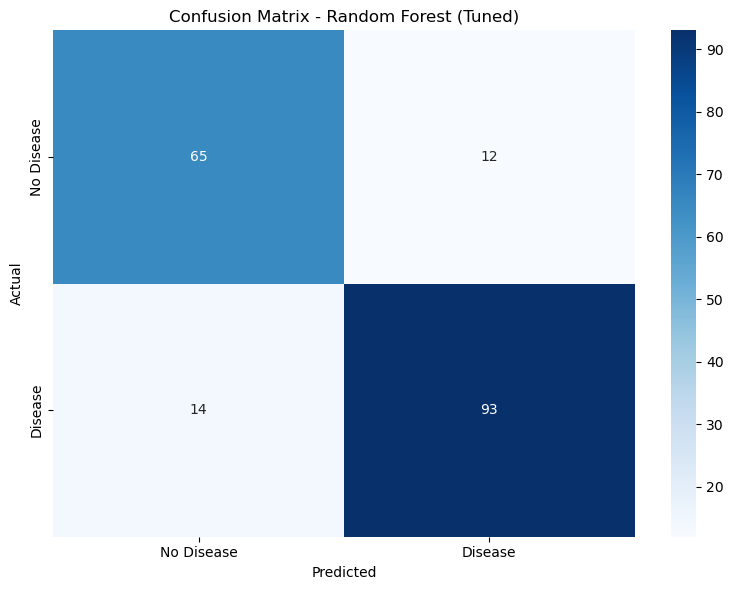

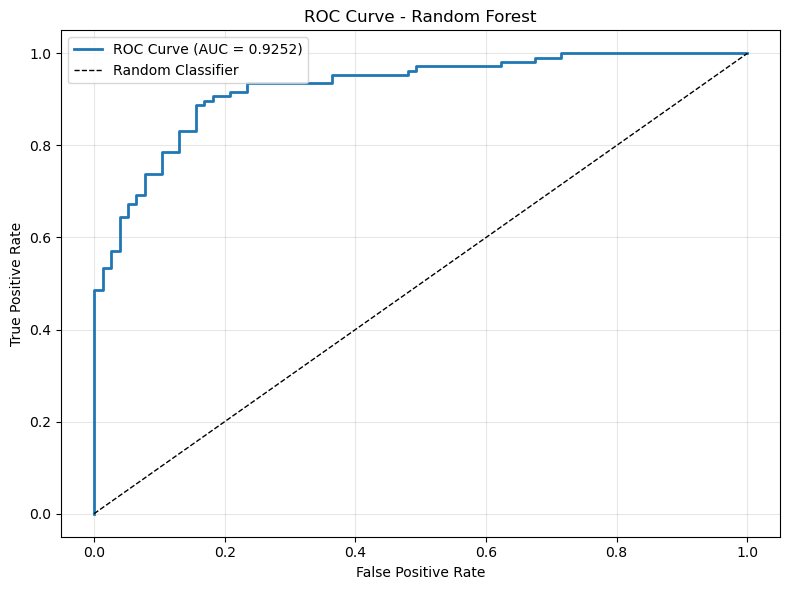


Random Forest AUC Score: 0.9252


In [ ]:
print('\n--- 7.8: Visualizations for Best Random Forest Model ---')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

rf_probs = best_rf_model.predict_proba(X_test_transformed)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'ROC Curve (AUC = {rf_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRandom Forest AUC Score: {rf_auc:.4f}")

In [ ]:
print('\n--- 7.9: Random Forest Model Comparison ---')

comparison_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Initial Model': [train_acc, test_acc, test_prec, test_rec, test_f1],
    'Tuned Model': [train_acc_best, test_acc_best, test_prec_best, test_rec_best, test_f1_best],
    'Improvement': [
        train_acc_best - train_acc,
        test_acc_best - test_acc,
        test_prec_best - test_prec,
        test_rec_best - test_rec,
        test_f1_best - test_f1
    ]
})

print(f"\n{'='*70}")
print("MODEL COMPARISON")
print(f"{'='*70}")
print(comparison_df.to_string(index=False))

rf_final_metrics = {
    'model': 'Random Forest',
    'test_acc': test_acc_best,
    'precision': test_prec_best,
    'recall': test_rec_best,
    'f1_score': test_f1_best,
    'auc': rf_auc,
    'fpr': rf_fpr,
    'tpr': rf_tpr
}


--- 7.9: Random Forest Model Comparison ---

MODEL COMPARISON
           Metric  Initial Model  Tuned Model  Improvement
Training Accuracy       0.982289     0.985014     0.002725
    Test Accuracy       0.858696     0.858696     0.000000
        Precision       0.885714     0.885714     0.000000
           Recall       0.869159     0.869159     0.000000
         F1-Score       0.877358     0.877358     0.000000


In [38]:
print("\n" + "="*80)
print("SECTION 7: DECISION TREE CLASSIFIER")
print("="*80)


SECTION 7: DECISION TREE CLASSIFIER


In [ ]:
print('\n--- 7.2: Training Decision Tree Models ---')

dt_gini = DecisionTreeClassifier(
    max_depth=5,
    criterion='gini',
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5
)
dt_gini.fit(X_train_transformed, y_train)

dt_entropy = DecisionTreeClassifier(
    max_depth=5,
    criterion='entropy',
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5
)
dt_entropy.fit(X_train_transformed, y_train)

print('Decision Tree with Gini Index trained!')
print('Decision Tree with Entropy trained!')
print(f'\nTree depth (Gini): {dt_gini.get_depth()}')
print(f'Tree depth (Entropy): {dt_entropy.get_depth()}')
print(f'Number of leaves (Gini): {dt_gini.get_n_leaves()}')
print(f'Number of leaves (Entropy): {dt_entropy.get_n_leaves()}')


--- 7.2: Training Decision Tree Models ---
Decision Tree with Gini Index trained!
Decision Tree with Entropy trained!

Tree depth (Gini): 5
Tree depth (Entropy): 5
Number of leaves (Gini): 22
Number of leaves (Entropy): 25


In [ ]:
print('\n--- 7.3: Model Evaluation Function ---')

def evaluate_decision_tree(model, X_train, X_test, y_train, y_test, title):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    
    print(f"\n{'='*70}")
    print(f"{title}")
    print(f"{'='*70}")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Precision:         {test_prec:.4f}")
    print(f"Recall:            {test_rec:.4f}")
    print(f"F1-Score:          {test_f1:.4f}")
    
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\nInterpretation:")
    print(f"  True Negatives (TN):  {cm[0,0]}")
    print(f"  False Positives (FP): {cm[0,1]}")
    print(f"  False Negatives (FN): {cm[1,0]}")
    print(f"  True Positives (TP):  {cm[1,1]}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred, digits=4))
    
    print(f"{'='*70}")
    print("OVERFITTING ANALYSIS")
    print(f"{'='*70}")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Difference:        {(train_acc - test_acc):.4f}")
    
    if (train_acc - test_acc) < 0.05:
        print("✓ Model shows good generalization (minimal overfitting)")
    elif (train_acc - test_acc) < 0.15:
        print("⚠ Model shows moderate overfitting")
    else:
        print("✗ Model shows significant overfitting - consider pruning or regularization")
    
    return {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': test_prec,
        'recall': test_rec,
        'f1_score': test_f1
    }

print('Evaluation function defined.')


--- 7.3: Model Evaluation Function ---
Evaluation function defined.


In [ ]:
print('\n--- 7.4: Evaluating Both Decision Tree Models ---')

gini_metrics = evaluate_decision_tree(
    dt_gini, 
    X_train_transformed, 
    X_test_transformed, 
    y_train, 
    y_test, 
    "Decision Tree - Gini Index"
)

entropy_metrics = evaluate_decision_tree(
    dt_entropy, 
    X_train_transformed, 
    X_test_transformed, 
    y_train, 
    y_test, 
    "Decision Tree - Entropy (Information Gain)"
)


--- 7.4: Evaluating Both Decision Tree Models ---

Decision Tree - Gini Index
Training Accuracy: 0.8828
Test Accuracy:     0.8315
Precision:         0.9043
Recall:            0.7944
F1-Score:          0.8458

Confusion Matrix:
[[68  9]
 [22 85]]

Interpretation:
  True Negatives (TN):  68
  False Positives (FP): 9
  False Negatives (FN): 22
  True Positives (TP):  85

Classification Report:
              precision    recall  f1-score   support

           0     0.7556    0.8831    0.8144        77
           1     0.9043    0.7944    0.8458       107

    accuracy                         0.8315       184
   macro avg     0.8299    0.8388    0.8301       184
weighted avg     0.8420    0.8315    0.8326       184

OVERFITTING ANALYSIS
Training Accuracy: 0.8828
Test Accuracy:     0.8315
Difference:        0.0513
⚠ Model shows moderate overfitting

Decision Tree - Entropy (Information Gain)
Training Accuracy: 0.8883
Test Accuracy:     0.7826
Precision:         0.8764
Recall:            0.7

In [ ]:
print('\n--- 7.5: Comparing Gini vs Entropy ---')

comparison_dt = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Gini Index': [
        gini_metrics['train_acc'],
        gini_metrics['test_acc'],
        gini_metrics['precision'],
        gini_metrics['recall'],
        gini_metrics['f1_score']
    ],
    'Entropy': [
        entropy_metrics['train_acc'],
        entropy_metrics['test_acc'],
        entropy_metrics['precision'],
        entropy_metrics['recall'],
        entropy_metrics['f1_score']
    ],
    'Difference': [
        entropy_metrics['train_acc'] - gini_metrics['train_acc'],
        entropy_metrics['test_acc'] - gini_metrics['test_acc'],
        entropy_metrics['precision'] - gini_metrics['precision'],
        entropy_metrics['recall'] - gini_metrics['recall'],
        entropy_metrics['f1_score'] - gini_metrics['f1_score']
    ]
})

print(f"\n{'='*70}")
print("GINI vs ENTROPY COMPARISON")
print(f"{'='*70}")
print(comparison_dt.to_string(index=False))

if gini_metrics['test_acc'] > entropy_metrics['test_acc']:
    print(f"\n✓ Gini Index performs better (Test Accuracy: {gini_metrics['test_acc']:.4f})")
    best_dt_model = dt_gini
    best_criterion = 'Gini'
elif entropy_metrics['test_acc'] > gini_metrics['test_acc']:
    print(f"\n✓ Entropy performs better (Test Accuracy: {entropy_metrics['test_acc']:.4f})")
    best_dt_model = dt_entropy
    best_criterion = 'Entropy'
else:
    print(f"\n→ Both criteria perform equally (Test Accuracy: {gini_metrics['test_acc']:.4f})")
    best_dt_model = dt_gini
    best_criterion = 'Gini'


--- 7.5: Comparing Gini vs Entropy ---

GINI vs ENTROPY COMPARISON
           Metric  Gini Index  Entropy  Difference
Training Accuracy    0.882834 0.888283    0.005450
    Test Accuracy    0.831522 0.782609   -0.048913
        Precision    0.904255 0.876404   -0.027851
           Recall    0.794393 0.728972   -0.065421
         F1-Score    0.845771 0.795918   -0.049853

✓ Gini Index performs better (Test Accuracy: 0.8315)



--- 7.6: Feature Importance Analysis ---

Top 10 Most Important Features (Decision Tree - Gini):
          Feature  Importance
      ST_Slope_Up    0.622266
 ExerciseAngina_Y    0.096123
            Sex_M    0.076189
          Oldpeak    0.075292
            MaxHR    0.038295
              Age    0.034691
        FastingBS    0.026431
        RestingBP    0.019097
      Cholesterol    0.011615
ChestPainType_ATA    0.000000


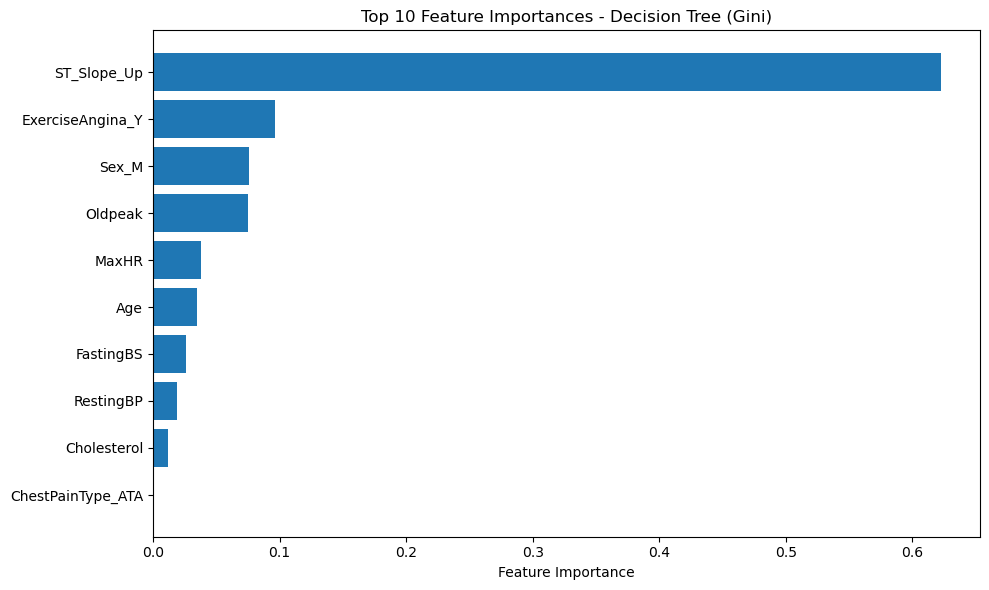

In [43]:
print('\n--- 7.6: Feature Importance Analysis ---')

dt_importances = best_dt_model.feature_importances_

dt_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
}).sort_values(by='Importance', ascending=False)

print(f'\nTop 10 Most Important Features (Decision Tree - {best_criterion}):')
print(dt_feature_importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(dt_feature_importance_df['Feature'][:10], dt_feature_importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.title(f'Top 10 Feature Importances - Decision Tree ({best_criterion})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


--- 7.7: Decision Tree Visualization ---


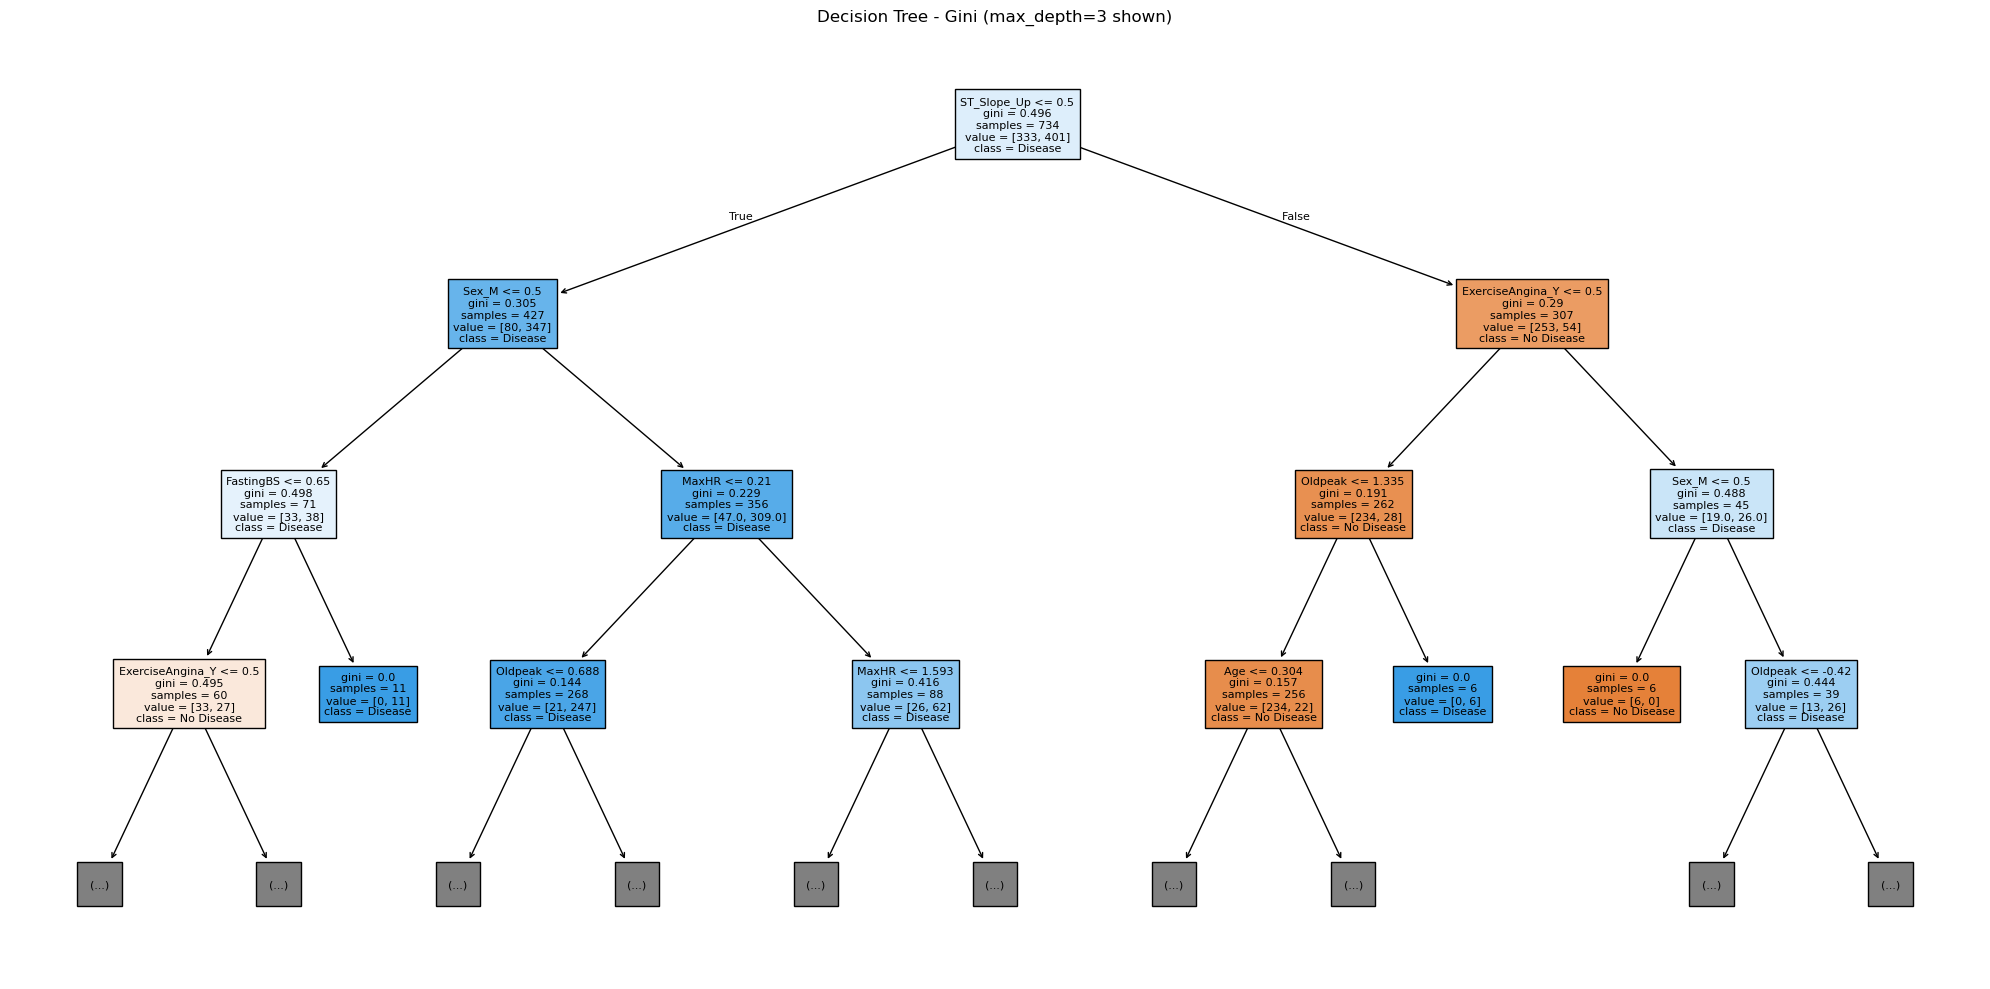

In [44]:
print('\n--- 7.7: Decision Tree Visualization ---')

plt.figure(figsize=(20, 10))
plot_tree(best_dt_model, 
          feature_names=feature_names, 
          class_names=['No Disease', 'Disease'],
          filled=True,
          max_depth=3,
          fontsize=8)
plt.title(f"Decision Tree - {best_criterion} (max_depth=3 shown)")
plt.tight_layout()
plt.show()

### 7.8 Hyperparameter Tuning for Decision Tree

In [45]:
print('\n--- 7.8: Hyperparameter Tuning with GridSearchCV ---')

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

print('Parameter grid for Decision Tree:')
for param, values in dt_param_grid.items():
    print(f'  {param}: {values}')

dt_base = DecisionTreeClassifier(random_state=42)

print('\nRunning GridSearchCV with 3-fold cross-validation...')

dt_grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=dt_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

dt_grid_search.fit(X_train_transformed, y_train)

print('\nGridSearchCV completed!')


--- 7.8: Hyperparameter Tuning with GridSearchCV ---
Parameter grid for Decision Tree:
  criterion: ['gini', 'entropy']
  max_depth: [3, 5, 7, 10]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 5]
  max_features: ['sqrt', 'log2', None]

Running GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

GridSearchCV completed!

GridSearchCV completed!


In [ ]:
print('\n--- 7.9: Best Decision Tree Model from Grid Search ---')

print(f"\n{'='*70}")
print("DECISION TREE - GRID SEARCH RESULTS")
print(f"{'='*70}")
print(f"\nBest parameters found:")
for param, value in dt_grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation score: {dt_grid_search.best_score_:.4f}")

best_dt_tuned = dt_grid_search.best_estimator_

tuned_dt_metrics = evaluate_decision_tree(
    best_dt_tuned,
    X_train_transformed,
    X_test_transformed,
    y_train,
    y_test,
    "Decision Tree - Best Model (Tuned)"
)


--- 7.9: Best Decision Tree Model from Grid Search ---

DECISION TREE - GRID SEARCH RESULTS

Best parameters found:
  criterion: gini
  max_depth: 7
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5

Best cross-validation score: 0.8433

Decision Tree - Best Model (Tuned)
Training Accuracy: 0.8978
Test Accuracy:     0.7554
Precision:         0.8370
Recall:            0.7196
F1-Score:          0.7739

Confusion Matrix:
[[62 15]
 [30 77]]

Interpretation:
  True Negatives (TN):  62
  False Positives (FP): 15
  False Negatives (FN): 30
  True Positives (TP):  77

Classification Report:
              precision    recall  f1-score   support

           0     0.6739    0.8052    0.7337        77
           1     0.8370    0.7196    0.7739       107

    accuracy                         0.7554       184
   macro avg     0.7554    0.7624    0.7538       184
weighted avg     0.7687    0.7554    0.7571       184

OVERFITTING ANALYSIS
Training Accuracy: 0.8978
Test Accuracy:     0


--- 7.10: Visualizations for Best Decision Tree Model ---


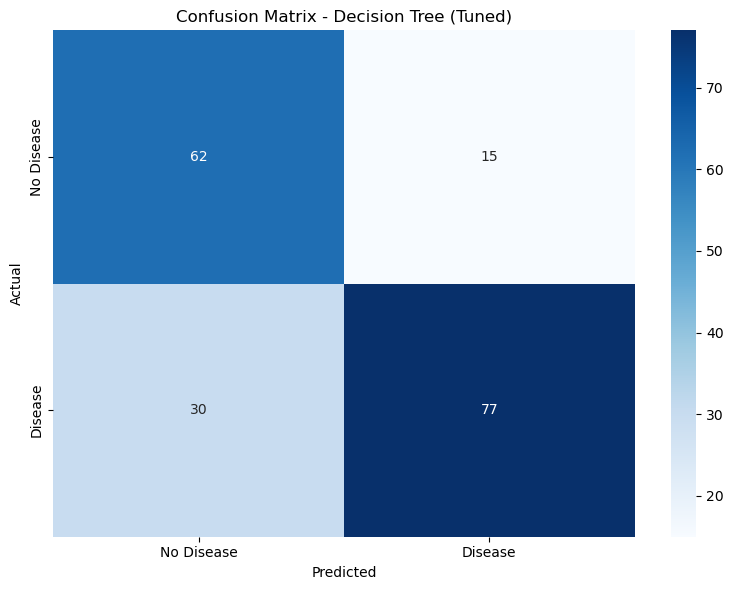

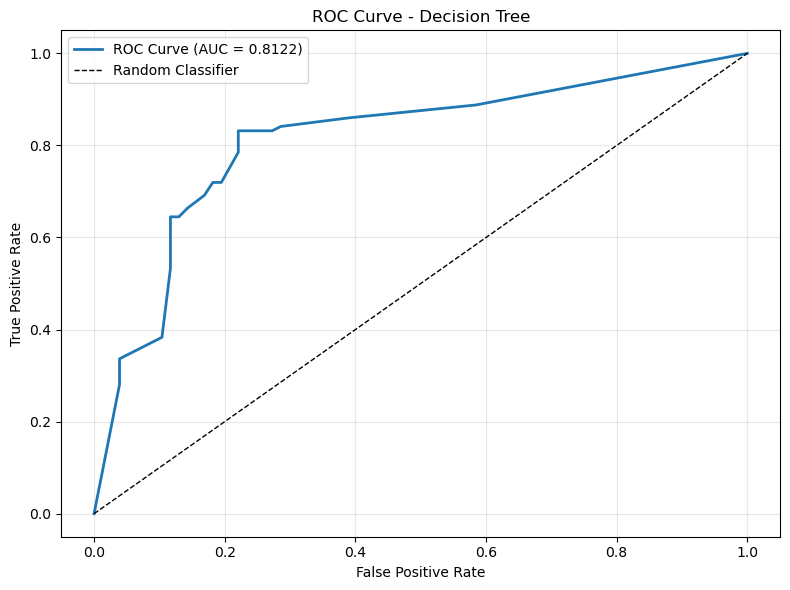


Decision Tree AUC Score: 0.8122


In [ ]:
print('\n--- 7.10: Visualizations for Best Decision Tree Model ---')

y_test_pred_dt_tuned = best_dt_tuned.predict(X_test_transformed)
cm_dt_tuned = confusion_matrix(y_test, y_test_pred_dt_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Decision Tree (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

dt_probs = best_dt_tuned.predict_proba(X_test_transformed)[:, 1]
dt_auc = roc_auc_score(y_test, dt_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f'ROC Curve (AUC = {dt_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDecision Tree AUC Score: {dt_auc:.4f}")

In [ ]:
print('\n--- 7.11: Decision Tree Model Comparison ---')

if gini_metrics['test_acc'] >= entropy_metrics['test_acc']:
    initial_metrics = gini_metrics
    initial_name = 'Gini'
else:
    initial_metrics = entropy_metrics
    initial_name = 'Entropy'

dt_comparison = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'],
    f'Initial ({initial_name})': [
        initial_metrics['train_acc'],
        initial_metrics['test_acc'],
        initial_metrics['precision'],
        initial_metrics['recall'],
        initial_metrics['f1_score']
    ],
    'Tuned Model': [
        tuned_dt_metrics['train_acc'],
        tuned_dt_metrics['test_acc'],
        tuned_dt_metrics['precision'],
        tuned_dt_metrics['recall'],
        tuned_dt_metrics['f1_score']
    ],
    'Improvement': [
        tuned_dt_metrics['train_acc'] - initial_metrics['train_acc'],
        tuned_dt_metrics['test_acc'] - initial_metrics['test_acc'],
        tuned_dt_metrics['precision'] - initial_metrics['precision'],
        tuned_dt_metrics['recall'] - initial_metrics['recall'],
        tuned_dt_metrics['f1_score'] - initial_metrics['f1_score']
    ]
})

print(f"\n{'='*70}")
print("DECISION TREE - MODEL COMPARISON")
print(f"{'='*70}")
print(dt_comparison.to_string(index=False))

dt_final_metrics = {
    'model': 'Decision Tree',
    'test_acc': tuned_dt_metrics['test_acc'],
    'precision': tuned_dt_metrics['precision'],
    'recall': tuned_dt_metrics['recall'],
    'f1_score': tuned_dt_metrics['f1_score'],
    'auc': dt_auc,
    'fpr': dt_fpr,
    'tpr': dt_tpr
}


--- 7.11: Decision Tree Model Comparison ---

DECISION TREE - MODEL COMPARISON
           Metric  Initial (Gini)  Tuned Model  Improvement
Training Accuracy        0.882834     0.897820     0.014986
    Test Accuracy        0.831522     0.755435    -0.076087
        Precision        0.904255     0.836957    -0.067299
           Recall        0.794393     0.719626    -0.074766
         F1-Score        0.845771     0.773869    -0.071902


## Section 8: Logistic Regression

**Logistic Regression** is a linear classifier that uses the sigmoid function to model the probability of a binary outcome.

**Key characteristics:**
- **Linear model:** Models the log-odds of the probability as a linear combination of features
- **Probability output:** Uses sigmoid function to output probabilities between 0 and 1
- **Interpretable:** Coefficients indicate feature importance and direction of effect

**Advantages:**
- Fast training and prediction
- Provides probability estimates
- Works well when features are linearly separable
- Easy to interpret coefficients

In [49]:
print("\n" + "="*80)
print("SECTION 8: LOGISTIC REGRESSION")
print("="*80)


SECTION 8: LOGISTIC REGRESSION


In [50]:
print('\n--- 8.1: Hyperparameter Tuning with GridSearchCV ---')

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500]
}

print('Parameter grid for Logistic Regression:')
for param, values in lr_param_grid.items():
    print(f'  {param}: {values}')

lr_base = LogisticRegression(random_state=42)

print('\nRunning GridSearchCV with 3-fold cross-validation...')

lr_grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=lr_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

lr_grid_search.fit(X_train_transformed, y_train)

print('\nGridSearchCV completed!')


--- 8.1: Hyperparameter Tuning with GridSearchCV ---
Parameter grid for Logistic Regression:
  C: [0.01, 0.1, 1, 10]
  solver: ['lbfgs', 'liblinear']
  max_iter: [100, 200, 500]

Running GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

GridSearchCV completed!
Fitting 3 folds for each of 24 candidates, totalling 72 fits

GridSearchCV completed!


In [51]:
print('\n--- 8.2: Best Model from Grid Search ---')

print(f"\n{'='*70}")
print("LOGISTIC REGRESSION - GRID SEARCH RESULTS")
print(f"{'='*70}")
print(f"\nBest parameters found:")
for param, value in lr_grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation score: {lr_grid_search.best_score_:.4f}")

best_lr_model = lr_grid_search.best_estimator_

y_train_pred_lr = best_lr_model.predict(X_train_transformed)
y_test_pred_lr = best_lr_model.predict(X_test_transformed)

lr_train_acc = accuracy_score(y_train, y_train_pred_lr)
lr_test_acc = accuracy_score(y_test, y_test_pred_lr)
lr_prec = precision_score(y_test, y_test_pred_lr, zero_division=0)
lr_rec = recall_score(y_test, y_test_pred_lr, zero_division=0)
lr_f1 = f1_score(y_test, y_test_pred_lr, zero_division=0)

print(f"\n{'='*70}")
print("BEST MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Training Accuracy: {lr_train_acc:.4f}")
print(f"Test Accuracy:     {lr_test_acc:.4f}")
print(f"Precision:         {lr_prec:.4f}")
print(f"Recall:            {lr_rec:.4f}")
print(f"F1-Score:          {lr_f1:.4f}")

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print(f"\n{'='*70}")
print("CONFUSION MATRIX")
print(f"{'='*70}")
print(cm_lr)

print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print(f"{'='*70}")
print(classification_report(y_test, y_test_pred_lr, digits=4))

print(f"\n{'='*70}")
print("OVERFITTING ANALYSIS")
print(f"{'='*70}")
print(f"Training Accuracy: {lr_train_acc:.4f}")
print(f"Test Accuracy:     {lr_test_acc:.4f}")
print(f"Difference:        {(lr_train_acc - lr_test_acc):.4f}")

if (lr_train_acc - lr_test_acc) < 0.05:
    print("✓ Model shows excellent generalization")
elif (lr_train_acc - lr_test_acc) < 0.15:
    print("⚠ Model shows acceptable generalization")
else:
    print("✗ Model shows overfitting")


--- 8.2: Best Model from Grid Search ---

LOGISTIC REGRESSION - GRID SEARCH RESULTS

Best parameters found:
  C: 0.1
  max_iter: 100
  solver: lbfgs

Best cross-validation score: 0.8569

BEST MODEL PERFORMANCE
Training Accuracy: 0.8610
Test Accuracy:     0.8587
Precision:         0.9010
Recall:            0.8505
F1-Score:          0.8750

CONFUSION MATRIX
[[67 10]
 [16 91]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.8072    0.8701    0.8375        77
           1     0.9010    0.8505    0.8750       107

    accuracy                         0.8587       184
   macro avg     0.8541    0.8603    0.8562       184
weighted avg     0.8618    0.8587    0.8593       184


OVERFITTING ANALYSIS
Training Accuracy: 0.8610
Test Accuracy:     0.8587
Difference:        0.0023
✓ Model shows excellent generalization



--- 8.3: Visualizations for Logistic Regression ---


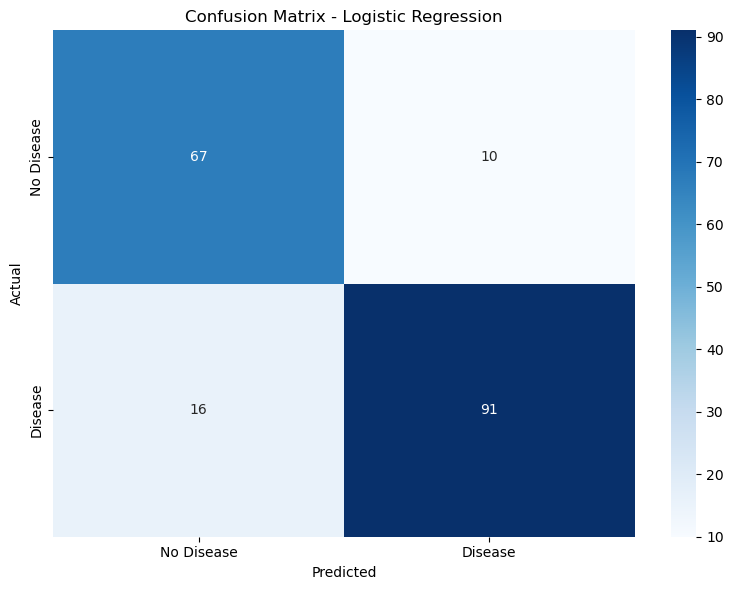

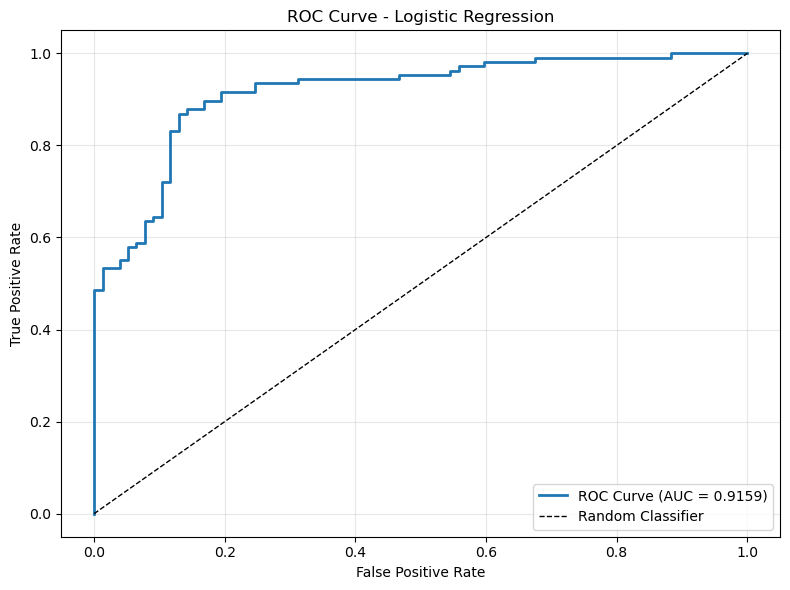


Logistic Regression AUC Score: 0.9159


In [ ]:
print('\n--- 8.3: Visualizations for Logistic Regression ---')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

lr_probs = best_lr_model.predict_proba(X_test_transformed)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'ROC Curve (AUC = {lr_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLogistic Regression AUC Score: {lr_auc:.4f}")

lr_final_metrics = {
    'model': 'Logistic Regression',
    'test_acc': lr_test_acc,
    'precision': lr_prec,
    'recall': lr_rec,
    'f1_score': lr_f1,
    'auc': lr_auc,
    'fpr': lr_fpr,
    'tpr': lr_tpr
}

## Section 9: K-Nearest Neighbors (KNN)

**K-Nearest Neighbors** is a non-parametric, instance-based classifier that classifies data points based on the majority vote of their k nearest neighbors.

**Key characteristics:**
- **Instance-based:** No explicit training phase, stores all training data
- **Non-parametric:** Makes no assumptions about data distribution
- **Distance-based:** Uses distance metrics (Euclidean, Manhattan) to find neighbors

**Advantages:**
- Simple and intuitive algorithm
- No training phase required
- Adapts to complex decision boundaries
- Works well when local patterns are important

In [53]:
print("\n" + "="*80)
print("SECTION 9: K-NEAREST NEIGHBORS (KNN)")
print("="*80)


SECTION 9: K-NEAREST NEIGHBORS (KNN)


In [54]:
print('\n--- 9.1: Hyperparameter Tuning with GridSearchCV ---')

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print('Parameter grid for KNN:')
for param, values in knn_param_grid.items():
    print(f'  {param}: {values}')

knn_base = KNeighborsClassifier()

print('\nRunning GridSearchCV with 3-fold cross-validation...')

knn_grid_search = GridSearchCV(
    estimator=knn_base,
    param_grid=knn_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

knn_grid_search.fit(X_train_transformed, y_train)

print('\nGridSearchCV completed!')


--- 9.1: Hyperparameter Tuning with GridSearchCV ---
Parameter grid for KNN:
  n_neighbors: [3, 5, 7, 9, 11]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan']

Running GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

GridSearchCV completed!

GridSearchCV completed!


In [55]:
print('\n--- 9.2: Best Model from Grid Search ---')

print(f"\n{'='*70}")
print("KNN - GRID SEARCH RESULTS")
print(f"{'='*70}")
print(f"\nBest parameters found:")
for param, value in knn_grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation score: {knn_grid_search.best_score_:.4f}")

best_knn_model = knn_grid_search.best_estimator_

y_train_pred_knn = best_knn_model.predict(X_train_transformed)
y_test_pred_knn = best_knn_model.predict(X_test_transformed)

knn_train_acc = accuracy_score(y_train, y_train_pred_knn)
knn_test_acc = accuracy_score(y_test, y_test_pred_knn)
knn_prec = precision_score(y_test, y_test_pred_knn, zero_division=0)
knn_rec = recall_score(y_test, y_test_pred_knn, zero_division=0)
knn_f1 = f1_score(y_test, y_test_pred_knn, zero_division=0)

print(f"\n{'='*70}")
print("BEST MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Training Accuracy: {knn_train_acc:.4f}")
print(f"Test Accuracy:     {knn_test_acc:.4f}")
print(f"Precision:         {knn_prec:.4f}")
print(f"Recall:            {knn_rec:.4f}")
print(f"F1-Score:          {knn_f1:.4f}")

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
print(f"\n{'='*70}")
print("CONFUSION MATRIX")
print(f"{'='*70}")
print(cm_knn)

print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print(f"{'='*70}")
print(classification_report(y_test, y_test_pred_knn, digits=4))

print(f"\n{'='*70}")
print("OVERFITTING ANALYSIS")
print(f"{'='*70}")
print(f"Training Accuracy: {knn_train_acc:.4f}")
print(f"Test Accuracy:     {knn_test_acc:.4f}")
print(f"Difference:        {(knn_train_acc - knn_test_acc):.4f}")

if (knn_train_acc - knn_test_acc) < 0.05:
    print("✓ Model shows excellent generalization")
elif (knn_train_acc - knn_test_acc) < 0.15:
    print("⚠ Model shows acceptable generalization")
else:
    print("✗ Model shows overfitting")


--- 9.2: Best Model from Grid Search ---

KNN - GRID SEARCH RESULTS

Best parameters found:
  metric: manhattan
  n_neighbors: 11
  weights: distance

Best cross-validation score: 0.8637

BEST MODEL PERFORMANCE
Training Accuracy: 1.0000
Test Accuracy:     0.8641
Precision:         0.8942
Recall:            0.8692
F1-Score:          0.8815

CONFUSION MATRIX
[[66 11]
 [14 93]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.8250    0.8571    0.8408        77
           1     0.8942    0.8692    0.8815       107

    accuracy                         0.8641       184
   macro avg     0.8596    0.8632    0.8611       184
weighted avg     0.8653    0.8641    0.8645       184


OVERFITTING ANALYSIS
Training Accuracy: 1.0000
Test Accuracy:     0.8641
Difference:        0.1359
⚠ Model shows acceptable generalization



--- 9.3: Visualizations for KNN ---


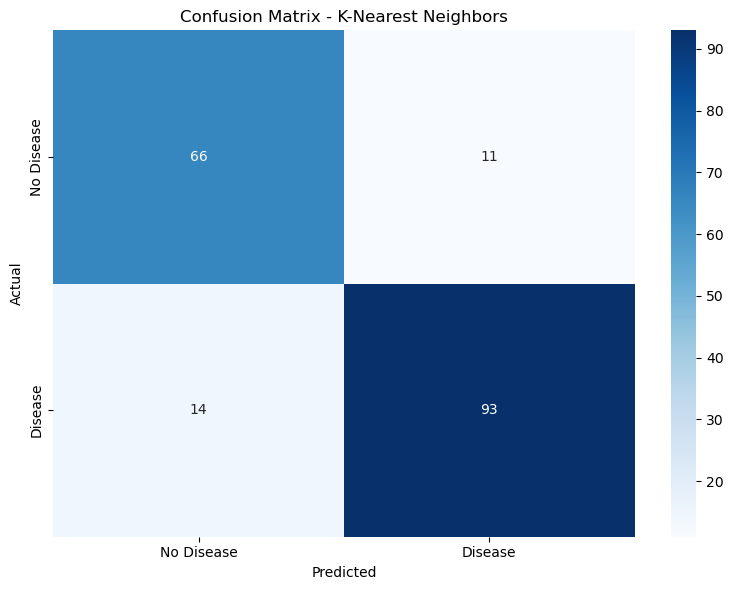

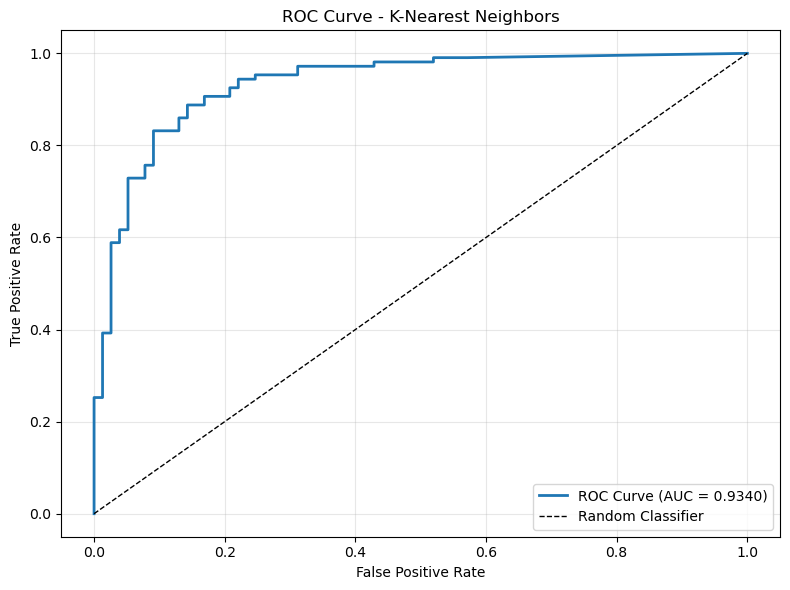


KNN AUC Score: 0.9340


In [ ]:
print('\n--- 9.3: Visualizations for KNN ---')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

knn_probs = best_knn_model.predict_proba(X_test_transformed)[:, 1]
knn_auc = roc_auc_score(y_test, knn_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

plt.figure(figsize=(8, 6))
plt.plot(knn_fpr, knn_tpr, label=f'ROC Curve (AUC = {knn_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Nearest Neighbors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nKNN AUC Score: {knn_auc:.4f}")

knn_final_metrics = {
    'model': 'K-Nearest Neighbors',
    'test_acc': knn_test_acc,
    'precision': knn_prec,
    'recall': knn_rec,
    'f1_score': knn_f1,
    'auc': knn_auc,
    'fpr': knn_fpr,
    'tpr': knn_tpr
}

## Section 10: Final Model Comparison

### Metric Selection Justification Based on Dataset Characteristics

For the **heart disease classification** problem, the choice of evaluation metrics is critical and must align with the dataset characteristics:

**Dataset Characteristics:**
- **Binary Classification:** HeartDisease (0 = No Disease, 1 = Disease)
- **Class Distribution:** The dataset has a relatively balanced distribution (approximately 55% positive, 45% negative)
- **Medical Domain:** False negatives (missing a heart disease case) are more costly than false positives

**Selected Metrics and Justification:**

| Metric | Justification |
|--------|---------------|
| **Accuracy** | Appropriate because the dataset is relatively balanced. With similar class proportions, accuracy provides a meaningful overall performance measure. |
| **Precision** | Important to understand how many predicted positive cases are actually positive. High precision reduces unnecessary medical interventions. |
| **Recall (Sensitivity)** | Critical in medical diagnosis - we want to minimize false negatives (missing actual disease cases). A missed diagnosis could be life-threatening. |
| **F1-Score** | Harmonic mean of precision and recall, providing a balanced measure when both metrics matter. Essential when we need a single metric that considers both false positives and false negatives. |
| **AUC-ROC** | Measures the model's ability to discriminate between classes across all thresholds. Particularly valuable because it's threshold-independent and robust to class imbalance variations. |

**Why These Metrics Together?**
- In medical diagnosis, **Recall is prioritized** because missing a disease case (false negative) has severe consequences
- However, **Precision also matters** to avoid unnecessary anxiety and medical procedures
- **F1-Score** balances both concerns
- **AUC** provides an overall discrimination ability measure, useful for comparing models regardless of threshold selection

In [57]:
print("\n" + "="*80)
print("SECTION 10: FINAL MODEL COMPARISON")
print("="*80)


SECTION 10: FINAL MODEL COMPARISON


In [ ]:
print('\n--- 10.1: Dataset Characteristics Analysis for Metric Selection ---')

class_distribution = y.value_counts()
total_samples = len(y)
positive_ratio = class_distribution[1] / total_samples * 100
negative_ratio = class_distribution[0] / total_samples * 100
imbalance_ratio = class_distribution.max() / class_distribution.min()

print(f"\n{'='*90}")
print("DATASET CHARACTERISTICS")
print(f"{'='*90}")
print(f"Total samples: {total_samples}")
print(f"Class 0 (No Disease): {class_distribution[0]} ({negative_ratio:.1f}%)")
print(f"Class 1 (Disease): {class_distribution[1]} ({positive_ratio:.1f}%)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

print(f"\n{'='*90}")
print("METRIC SELECTION JUSTIFICATION")
print(f"{'='*90}")

if imbalance_ratio < 1.5:
    balance_status = "BALANCED"
    print(f"✓ Dataset is {balance_status} (ratio < 1.5:1)")
    print("  → Accuracy is a valid primary metric")
elif imbalance_ratio < 3:
    balance_status = "MODERATELY IMBALANCED"
    print(f"⚠ Dataset is {balance_status} (ratio between 1.5:1 and 3:1)")
    print("  → F1-Score and AUC should be prioritized over Accuracy")
else:
    balance_status = "HIGHLY IMBALANCED"
    print(f"✗ Dataset is {balance_status} (ratio > 3:1)")
    print("  → Accuracy is misleading; use Precision, Recall, F1, and AUC")

print(f"\nFor MEDICAL DIAGNOSIS (Heart Disease):")
print("  → RECALL is critical: Missing a disease case (FN) can be life-threatening")
print("  → PRECISION matters: Reduces unnecessary medical interventions")
print("  → F1-SCORE: Balances both concerns")
print("  → AUC: Threshold-independent measure of discrimination ability")


--- 10.1: Model Performance Summary ---

ALL MODELS COMPARISON (Sorted by Test Accuracy)
              Model  Test Accuracy  Precision   Recall  F1-Score      AUC
K-Nearest Neighbors       0.864130   0.894231 0.869159  0.881517 0.934033
      Random Forest       0.858696   0.885714 0.869159  0.877358 0.925234
Logistic Regression       0.858696   0.900990 0.850467  0.875000 0.915888
      Decision Tree       0.755435   0.836957 0.719626  0.773869 0.812234

BEST MODEL RECOMMENDATION
✓ Best performing model: K-Nearest Neighbors
  - Test Accuracy: 0.8641
  - AUC Score: 0.9340


In [ ]:
print('\n--- 10.2: Model Performance Summary ---')

all_metrics = [rf_final_metrics, dt_final_metrics, lr_final_metrics, knn_final_metrics]

comparison_summary = pd.DataFrame({
    'Model': [m['model'] for m in all_metrics],
    'Test Accuracy': [m['test_acc'] for m in all_metrics],
    'Precision': [m['precision'] for m in all_metrics],
    'Recall': [m['recall'] for m in all_metrics],
    'F1-Score': [m['f1_score'] for m in all_metrics],
    'AUC': [m['auc'] for m in all_metrics]
})

comparison_summary = comparison_summary.sort_values(by='Test Accuracy', ascending=False)

print(f"\n{'='*90}")
print("ALL MODELS COMPARISON (Sorted by Test Accuracy)")
print(f"{'='*90}")
print(comparison_summary.to_string(index=False))

In [ ]:
print('\n--- 10.3: Justified Model Comparison ---')

print(f"\n{'='*90}")
print("JUSTIFIED PERFORMANCE COMPARISON")
print(f"{'='*90}")

best_by_accuracy = comparison_summary.loc[comparison_summary['Test Accuracy'].idxmax()]
best_by_recall = comparison_summary.loc[comparison_summary['Recall'].idxmax()]
best_by_f1 = comparison_summary.loc[comparison_summary['F1-Score'].idxmax()]
best_by_auc = comparison_summary.loc[comparison_summary['AUC'].idxmax()]

print(f"\n1. ACCURACY ANALYSIS:")
print(f"   Best model: {best_by_accuracy['Model']} ({best_by_accuracy['Test Accuracy']:.4f})")
print(f"   Since dataset is relatively balanced, accuracy is a valid metric.")
print(f"   Higher accuracy indicates better overall correct predictions.")

print(f"\n2. RECALL ANALYSIS (Critical for Medical Diagnosis):")
print(f"   Best model: {best_by_recall['Model']} ({best_by_recall['Recall']:.4f})")
print(f"   High recall minimizes false negatives (missed disease cases).")
print(f"   In heart disease detection, missing a positive case could be fatal.")

print(f"\n3. F1-SCORE ANALYSIS:")
print(f"   Best model: {best_by_f1['Model']} ({best_by_f1['F1-Score']:.4f})")
print(f"   F1-Score balances precision and recall.")
print(f"   Best choice when both false positives and false negatives matter.")

print(f"\n4. AUC-ROC ANALYSIS:")
print(f"   Best model: {best_by_auc['Model']} ({best_by_auc['AUC']:.4f})")
print(f"   AUC measures discrimination ability across all thresholds.")
print(f"   Higher AUC indicates better class separation capability.")

print(f"\n{'='*90}")
print("FINAL RECOMMENDATION")
print(f"{'='*90}")

if best_by_recall['Model'] == best_by_f1['Model'] == best_by_auc['Model']:
    recommended_model = best_by_recall['Model']
    print(f"✓ CLEAR WINNER: {recommended_model}")
    print(f"  Dominates in Recall, F1-Score, and AUC - the most critical metrics.")
else:
    recommended_model = best_by_recall['Model']
    print(f"✓ RECOMMENDED: {recommended_model}")
    print(f"  Prioritized for highest Recall - critical in medical diagnosis.")
    print(f"  Missing a heart disease case (False Negative) has severe consequences.")

print(f"\nJUSTIFICATION:")
print(f"  For medical classification problems like heart disease prediction:")
print(f"  1. Recall is prioritized because false negatives are life-threatening")
print(f"  2. AUC provides threshold-independent model comparison")
print(f"  3. F1-Score offers a balanced view when both errors matter")
print(f"  4. Accuracy is informative given the balanced dataset")


--- 10.2: Combined ROC Curves ---


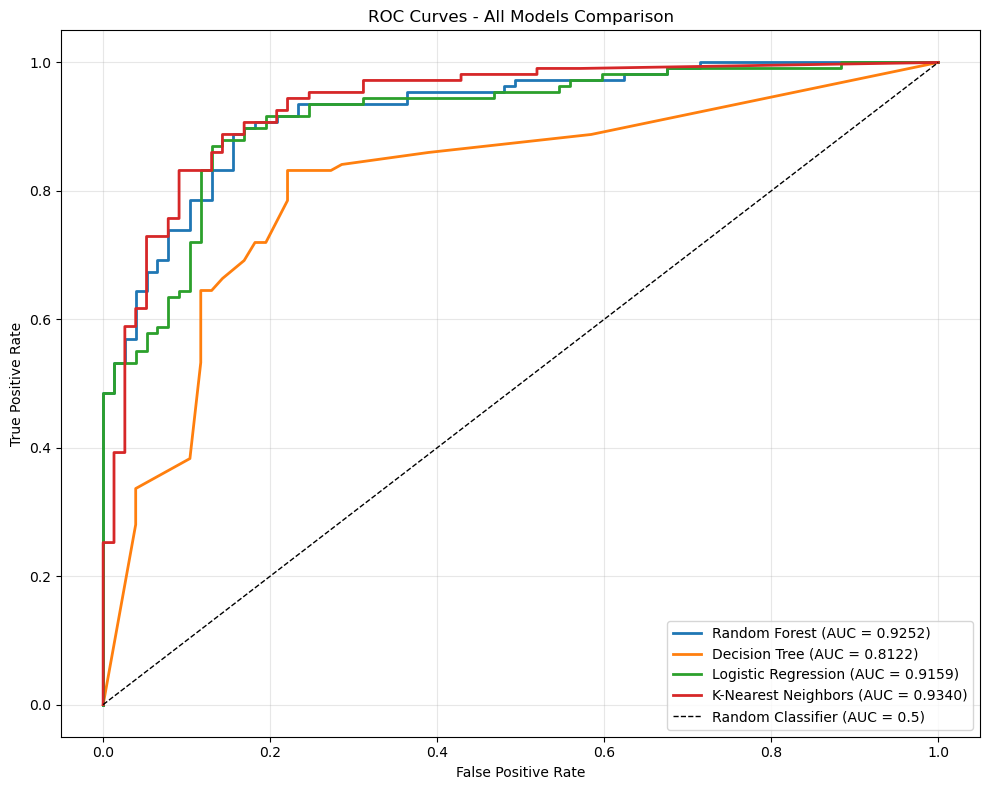

In [ ]:
print('\n--- 10.4: Combined ROC Curves ---')

plt.figure(figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, metrics in enumerate(all_metrics):
    plt.plot(metrics['fpr'], metrics['tpr'], 
             label=f"{metrics['model']} (AUC = {metrics['auc']:.4f})", 
             linewidth=2, color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nROC Curve Interpretation:")
print("  - Curves closer to top-left corner indicate better performance")
print("  - AUC = 1.0 represents perfect classification")
print("  - AUC = 0.5 represents random guessing (diagonal line)")
print("  - Higher AUC = better ability to distinguish between classes")


--- 10.3: Model Metrics Visualization ---


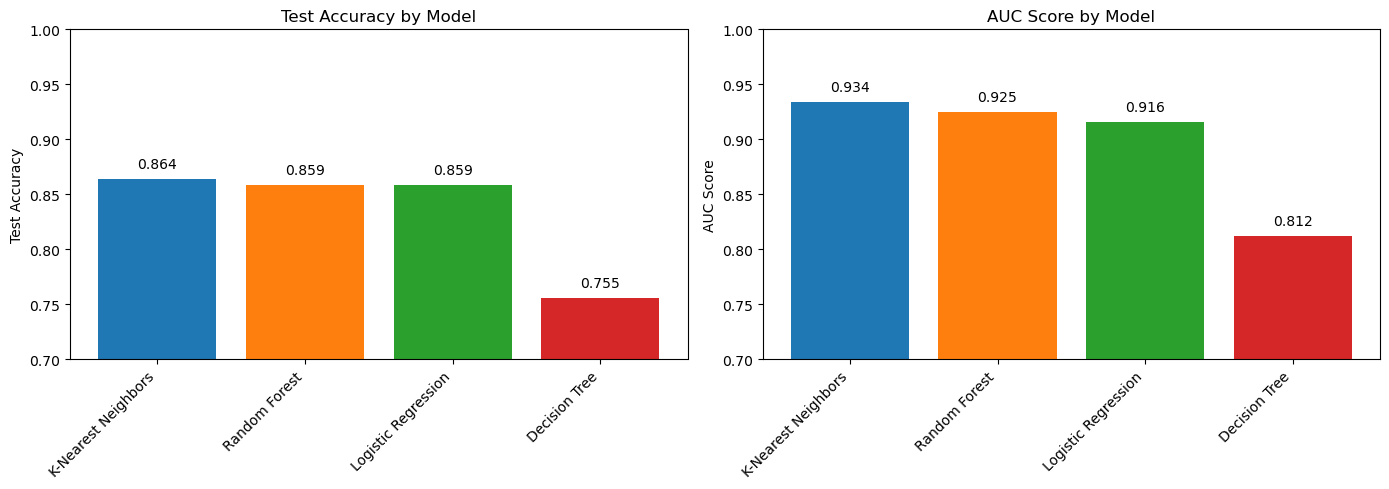


ANALYSIS COMPLETE


In [ ]:
print('\n--- 10.5: Model Metrics Visualization ---')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = comparison_summary['Model'].tolist()
x_pos = np.arange(len(models))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

axes[0, 0].bar(x_pos, comparison_summary['Test Accuracy'], color=colors)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy by Model')
axes[0, 0].set_ylim([0.7, 1.0])
for i, v in enumerate(comparison_summary['Test Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

axes[0, 1].bar(x_pos, comparison_summary['Recall'], color=colors)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('Recall by Model (Critical for Medical Diagnosis)')
axes[0, 1].set_ylim([0.7, 1.0])
for i, v in enumerate(comparison_summary['Recall']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

axes[1, 0].bar(x_pos, comparison_summary['F1-Score'], color=colors)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score by Model (Balance of Precision & Recall)')
axes[1, 0].set_ylim([0.7, 1.0])
for i, v in enumerate(comparison_summary['F1-Score']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

axes[1, 1].bar(x_pos, comparison_summary['AUC'], color=colors)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].set_ylabel('AUC Score')
axes[1, 1].set_title('AUC Score by Model (Discrimination Ability)')
axes[1, 1].set_ylim([0.7, 1.0])
for i, v in enumerate(comparison_summary['AUC']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()